In [6]:
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from utils_font_classifier import FontDataset, FontClassifier

### Look at data whe are using for training

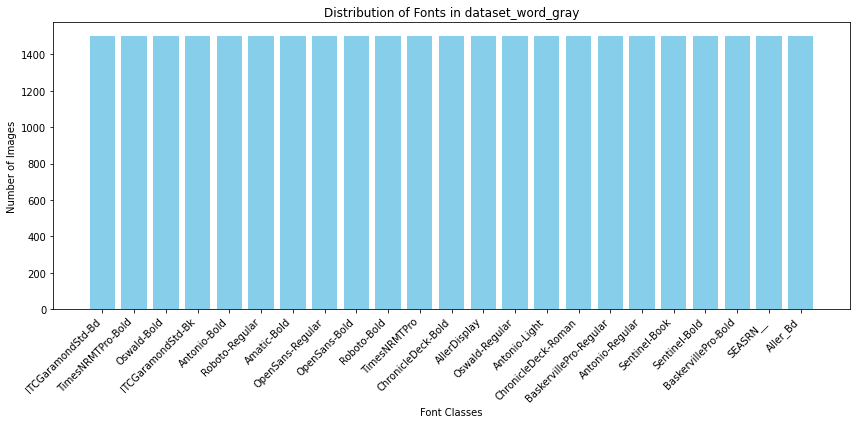

In [13]:
# Define the paths to the CSV files
csv_paths = {
    "dataset_word_gray": "dataset_word_gray.csv",
    "dataset_word_gray_sub": "dataset_word_gray_sub.csv"
}

# Function to plot the number of images per font from a CSV file
def plot_font_distribution(csv_path, title):
    # Read the CSV file
    data = pd.read_csv(csv_path)
    
    # Count the occurrences of each font
    font_counter = Counter(data["font"])
    font_classes, font_counts = zip(*font_counter.most_common())

    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(font_classes, font_counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Font Classes")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the distributions for the dataset
plot_font_distribution(csv_paths["dataset_word_gray_sub"], "Distribution of Fonts in dataset_word_gray")

In [14]:
# Load the dataset
dataset = FontDataset(csv_paths["dataset_word_gray_sub"])

In [15]:
len(dataset)

34499

In [16]:
# Split into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
len(train_loader)

755

In [18]:
# Initialize the model
num_classes = len(pd.Categorical(pd.read_csv(csv_paths["dataset_word_gray_sub"])["font"]).categories)
print(num_classes)

model = FontClassifier(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

23


In [14]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        i=0
        for images_path, labels in train_loader:
            print(i)
            i+=1    
            plt.imshow(Image.open(images_path[0]).convert("RGB"))

            images = torch.stack(
                [torch.tensor(np.array(Image.open(p).convert("RGB")) / 255.0, dtype=torch.float32).permute(2, 0, 1) for p in images_path]
            ).to(device)            
            
            labels = torch.tensor(labels)
            labels = labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images_path, labels in val_loader:
                images = torch.stack(
                [torch.tensor(np.array(Image.open(p).convert("RGB")) / 255.0, dtype=torch.float32).permute(2, 0, 1) for p in images_path]
                ).to(device)  
                labels = torch.tensor(labels)
                labels = labels.to(device)
                labels = labels.long()


                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        torch.save(model.state_dict(), 'model_weights')

0


/var/folders/7t/0nrx2cz904vd8vf6qt5jttqm0000gn/T/ipykernel_1785/114339990.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/var/folders/7t/0nrx2cz904vd8vf6qt5jttqm0000gn/T/ipykernel_1785/114339990.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Epoch 1/10, Train Loss: 2.1051, Train Acc: 0.2911, Val Loss: 1.2544, Val Acc: 0.5616
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
2

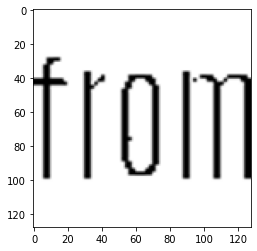

In [20]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [ ]:
# Copied epoch values
Epoch 1/10, Train Loss: 2.1051, Train Acc: 0.2911, Val Loss: 1.2544, Val Acc: 0.5616
Epoch 2/10, Train Loss: 1.3964, Train Acc: 0.4795, Val Loss: 0.9848, Val Acc: 0.6513
Epoch 3/10, Train Loss: 1.1954, Train Acc: 0.5509, Val Loss: 0.8918, Val Acc: 0.6894
Epoch 4/10, Train Loss: 1.0634, Train Acc: 0.5941, Val Loss: 0.8246, Val Acc: 0.7162
Epoch 5/10, Train Loss: 0.9633, Train Acc: 0.6257, Val Loss: 0.7859, Val Acc: 0.7186
Epoch 6/10, Train Loss: 0.8762, Train Acc: 0.6609, Val Loss: 0.7615, Val Acc: 0.7423
Epoch 7/10, Train Loss: 0.8235, Train Acc: 0.6827, Val Loss: 0.7375, Val Acc: 0.7494
Epoch 8/10, Train Loss: 0.7852, Train Acc: 0.6920, Val Loss: 0.7387, Val Acc: 0.7467
Epoch 9/10, Train Loss: 0.7216, Train Acc: 0.7175, Val Loss: 0.7354, Val Acc: 0.7579
Epoch 10/10, Train Loss: 0.6830, Train Acc: 0.7353, Val Loss: 0.7344, Val Acc: 0.7659


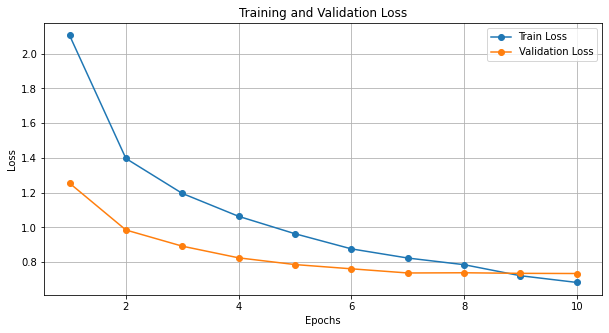

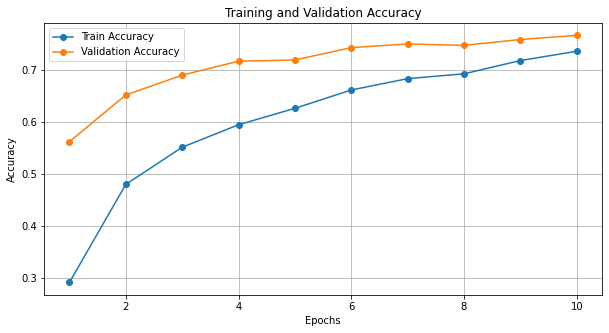

In [22]:
# Données réelles
epochs = range(1, 11)  # 10 époques
train_loss = [2.1051, 1.3964, 1.1954, 1.0634, 0.9633, 0.8762, 0.8235, 0.7852, 0.7216, 0.6830]
train_acc = [0.2911, 0.4795, 0.5509, 0.5941, 0.6257, 0.6609, 0.6827, 0.6920, 0.7175, 0.7353]
val_loss = [1.2544, 0.9848, 0.8918, 0.8246, 0.7859, 0.7615, 0.7375, 0.7387, 0.7354, 0.7344]
val_acc = [0.5616, 0.6513, 0.6894, 0.7162, 0.7186, 0.7423, 0.7494, 0.7467, 0.7579, 0.7659]

# Graphique des pertes
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Graphique des précisions
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()